<a href="https://colab.research.google.com/github/FICGAN-classification/FICGAN/blob/main/FICGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
# Import TensorFlow >= 1.10 and enable eager execution
import tensorflow as tf
tf.enable_eager_execution()
# import cv2 as cv
import scipy.misc

import os
import time
import numpy as np
import matplotlib.pyplot as plt
import PIL
from IPython.display import clear_output
from PIL import Image

import sys
print(sys.version)


3.7.10 (default, May  3 2021, 02:48:31) 
[GCC 7.5.0]


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
cd /content/drive/My Drive/dataset/

/content/drive/My Drive/dataset


In [5]:
te=1
#PATH = 'E:/Jafar/Pix2Pix/Inpaint/reco_Image/10/test_'+str(te)+'/'
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256 
IMG_HEIGHT = 256
EPOCHS = 1

def load_image(image_file, is_train):
  image = tf.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  w = tf.shape(image)[1]

  w = w // 2
  real_image = image[:, :w, :]
  input_image = image[:, w:, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  if is_train:
    # random jittering
    
    # resizing to 286 x 286 x 3
    input_image = tf.image.resize_images(input_image, [286, 286],align_corners=True, 
                                        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize_images(real_image, [286, 286], 
                                        align_corners=True, 
                                        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    # randomly cropping to 256 x 256 x 3
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])
    input_image, real_image = cropped_image[0], cropped_image[1]

    if np.random.random() > 0.5:
      # random mirroring
      input_image = tf.image.flip_left_right(input_image)
      real_image = tf.image.flip_left_right(real_image)
  else:
    input_image = tf.image.resize_images(input_image, size=[IMG_HEIGHT, IMG_WIDTH], 
                                         align_corners=True, method=2)
    real_image = tf.image.resize_images(real_image, size=[IMG_HEIGHT, IMG_WIDTH], 
                                        align_corners=True, method=2)
  
  # normalizing the images to [-1, 1]
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image


In [6]:
train_dataset = tf.data.Dataset.list_files('train/*.jpg')
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.map(lambda x: load_image(x, True))
train_dataset = train_dataset.batch(1)

test_dataset = tf.data.Dataset.list_files('test/*.jpg')
test_dataset = test_dataset.map(lambda x: load_image(x, False))
test_dataset = test_dataset.batch(1)

'''

Write the generator and discriminator models

    Generator
        The architecture of generator is a modified U-Net.
        Each block in the encoder is (Conv -> Batchnorm -> Leaky ReLU)
        Each block in the decoder is (Transposed Conv -> Batchnorm -> Dropout(applied to the first 3 blocks) -> ReLU)
        There are skip connections between the encoder and decoder (as in U-Net).

    Discriminator
        The Discriminator is a PatchGAN.
        Each block in the discriminator is (Conv -> BatchNorm -> Leaky ReLU)
        The shape of the output after the last layer is (batch_size, 30, 30, 1)
        Each 30x30 patch of the output classifies a 70x70 portion of the input image (such an architecture is called a PatchGAN).
        Discriminator receives 2 inputs.
            Input image and the target image, which it should classify as real.
            Input image and the generated image (output of generator), which it should classify as fake.
            We concatenate these 2 inputs together in the code (tf.concat([inp, tar], axis=-1))

    Shape of the input travelling through the generator and the discriminator is in the comments in the code.

To learn more about the architecture and the hyperparameters you can refer the paper.
'''


'\n\nWrite the generator and discriminator models\n\n    Generator\n        The architecture of generator is a modified U-Net.\n        Each block in the encoder is (Conv -> Batchnorm -> Leaky ReLU)\n        Each block in the decoder is (Transposed Conv -> Batchnorm -> Dropout(applied to the first 3 blocks) -> ReLU)\n        There are skip connections between the encoder and decoder (as in U-Net).\n\n    Discriminator\n        The Discriminator is a PatchGAN.\n        Each block in the discriminator is (Conv -> BatchNorm -> Leaky ReLU)\n        The shape of the output after the last layer is (batch_size, 30, 30, 1)\n        Each 30x30 patch of the output classifies a 70x70 portion of the input image (such an architecture is called a PatchGAN).\n        Discriminator receives 2 inputs.\n            Input image and the target image, which it should classify as real.\n            Input image and the generated image (output of generator), which it should classify as fake.\n            We c

In [7]:

OUTPUT_CHANNELS = 3

class Downsample(tf.keras.Model):
    
  def __init__(self, filters, size, apply_batchnorm=True):
    super(Downsample, self).__init__()
    self.apply_batchnorm = apply_batchnorm
    initializer = tf.random_normal_initializer(0., 0.02)

    self.conv1 = tf.keras.layers.Conv2D(filters, 
                                        (size, size), 
                                        strides=2, 
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False)
    if self.apply_batchnorm:
        self.batchnorm = tf.keras.layers.BatchNormalization()
  
  def call(self, x, training):
    x = self.conv1(x)
    if self.apply_batchnorm:
        x = self.batchnorm(x, training=training)
    x = tf.nn.leaky_relu(x)
    return x 


class Upsample(tf.keras.Model):
    
  def __init__(self, filters, size, apply_dropout=False):
    super(Upsample, self).__init__()
    self.apply_dropout = apply_dropout
    initializer = tf.random_normal_initializer(0., 0.02)

    self.up_conv = tf.keras.layers.Conv2DTranspose(filters, 
                                                   (size, size), 
                                                   strides=2, 
                                                   padding='same',
                                                   kernel_initializer=initializer,
                                                   use_bias=False)
    self.batchnorm = tf.keras.layers.BatchNormalization()
    if self.apply_dropout:
        self.dropout = tf.keras.layers.Dropout(0.5)

  def call(self, x1, x2, training):
    x = self.up_conv(x1)
    x = self.batchnorm(x, training=training)
    if self.apply_dropout:
        x = self.dropout(x, training=training)
    x = tf.nn.relu(x)
    x = tf.concat([x, x2], axis=-1)
    return x


class Generator(tf.keras.Model):
    
  def __init__(self):
    super(Generator, self).__init__()
    initializer = tf.random_normal_initializer(0., 0.02)
    
    self.down1 = Downsample(64, 4, apply_batchnorm=False)
    self.down2 = Downsample(128, 4)
    self.down3 = Downsample(256, 4)
    self.down4 = Downsample(512, 4)
    self.down5 = Downsample(512, 4)
    self.down6 = Downsample(512, 4)
    self.down7 = Downsample(512, 4)
    self.down8 = Downsample(512, 4)

    self.up1 = Upsample(512, 4, apply_dropout=True)
    self.up2 = Upsample(512, 4, apply_dropout=True)
    self.up3 = Upsample(512, 4, apply_dropout=True)
    self.up4 = Upsample(512, 4)
    self.up5 = Upsample(256, 4)
    self.up6 = Upsample(128, 4)
    self.up7 = Upsample(64, 4)

    self.last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 
                                                (4, 4), 
                                                strides=2, 
                                                padding='same',
                                                kernel_initializer=initializer)
  
  @tf.contrib.eager.defun
  def call(self, x, training):
    # x shape == (bs, 256, 256, 3)    
    x1 = self.down1(x, training=training) # (bs, 128, 128, 64)
    x2 = self.down2(x1, training=training) # (bs, 64, 64, 128)
    x3 = self.down3(x2, training=training) # (bs, 32, 32, 256)
    x4 = self.down4(x3, training=training) # (bs, 16, 16, 512)
    x5 = self.down5(x4, training=training) # (bs, 8, 8, 512)
    x6 = self.down6(x5, training=training) # (bs, 4, 4, 512)
    x7 = self.down7(x6, training=training) # (bs, 2, 2, 512)
    x8 = self.down8(x7, training=training) # (bs, 1, 1, 512)

    x9 = self.up1(x8, x7, training=training) # (bs, 2, 2, 1024)
    x10 = self.up2(x9, x6, training=training) # (bs, 4, 4, 1024)
    x11 = self.up3(x10, x5, training=training) # (bs, 8, 8, 1024)
    x12 = self.up4(x11, x4, training=training) # (bs, 16, 16, 1024)
    x13 = self.up5(x12, x3, training=training) # (bs, 32, 32, 512)
    x14 = self.up6(x13, x2, training=training) # (bs, 64, 64, 256)
    x15 = self.up7(x14, x1, training=training) # (bs, 128, 128, 128)

    x16 = self.last(x15) # (bs, 256, 256, 3)
    x16 = tf.nn.tanh(x16)

    return x16

class DiscDownsample(tf.keras.Model):
    
  def __init__(self, filters, size, apply_batchnorm=True):
    super(DiscDownsample, self).__init__()
    self.apply_batchnorm = apply_batchnorm
    initializer = tf.random_normal_initializer(0., 0.02)

    self.conv1 = tf.keras.layers.Conv2D(filters, 
                                        (size, size), 
                                        strides=2, 
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False)
    if self.apply_batchnorm:
        self.batchnorm = tf.keras.layers.BatchNormalization()
  
  def call(self, x, training):
    x = self.conv1(x)
    if self.apply_batchnorm:
        x = self.batchnorm(x, training=training)
    x = tf.nn.leaky_relu(x)
    return x 

class Discriminator(tf.keras.Model):
    
  def __init__(self):
    super(Discriminator, self).__init__()
    initializer = tf.random_normal_initializer(0., 0.02)
    
    self.down1 = DiscDownsample(64, 4, False)
    self.down2 = DiscDownsample(128, 4)
    self.down3 = DiscDownsample(256, 4)
    
    # we are zero padding here with 1 because we need our shape to 
    # go from (batch_size, 32, 32, 256) to (batch_size, 31, 31, 512)
    self.zero_pad1 = tf.keras.layers.ZeroPadding2D()
    self.conv = tf.keras.layers.Conv2D(512, 
                                       (4, 4), 
                                       strides=1, 
                                       kernel_initializer=initializer, 
                                       use_bias=False)
    self.batchnorm1 = tf.keras.layers.BatchNormalization()
    
    # shape change from (batch_size, 31, 31, 512) to (batch_size, 30, 30, 1)
    self.zero_pad2 = tf.keras.layers.ZeroPadding2D()
    self.last = tf.keras.layers.Conv2D(1, 
                                       (4, 4), 
                                       strides=1,
                                       kernel_initializer=initializer)
    
  
  @tf.contrib.eager.defun
  def call(self, inp, tar, training):
    # concatenating the input and the target
    x = tf.concat([inp, tar], axis=-1) # (bs, 256, 256, channels*2)
    x = self.down1(x, training=training) # (bs, 128, 128, 64)
    x = self.down2(x, training=training) # (bs, 64, 64, 128)
    x = self.down3(x, training=training) # (bs, 32, 32, 256)

    x = self.zero_pad1(x) # (bs, 34, 34, 256)
    x = self.conv(x)      # (bs, 31, 31, 512)
    x = self.batchnorm1(x, training=training)
    x = tf.nn.leaky_relu(x)
    
    x = self.zero_pad2(x) # (bs, 33, 33, 512)
    # don't add a sigmoid activation here since
    # the loss function expects raw logits.
    x = self.last(x)      # (bs, 30, 30, 1)
  #  print("xxxxxxxxx=====",x)
    return x

# The call function of Generator and Discriminator have been decorated
# with tf.contrib.eager.defun()
# We get a performance speedup if defun is used (~25 seconds per epoch)
generator = Generator()
discriminator = Discriminator()

'''

Define the loss functions and the optimizer

    Discriminator loss
        The discriminator loss function takes 2 inputs; real images, generated images
        real_loss is a sigmoid cross entropy loss of the real images and an array of ones(since these are the real images)
        generated_loss is a sigmoid cross entropy loss of the generated images and an array of zeros(since these are the fake images)
        Then the total_loss is the sum of real_loss and the generated_loss

    Generator loss
        It is a sigmoid cross entropy loss of the generated images and an array of ones.
        The paper also includes L1 loss which is MAE (mean absolute error) between the generated image and the target image.
        This allows the generated image to become structurally similar to the target image.
        The formula to calculate the total generator loss = gan_loss + LAMBDA * l1_loss, where LAMBDA = 100. This value was decided by the authors of the paper.

'''

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



'\n\nDefine the loss functions and the optimizer\n\n    Discriminator loss\n        The discriminator loss function takes 2 inputs; real images, generated images\n        real_loss is a sigmoid cross entropy loss of the real images and an array of ones(since these are the real images)\n        generated_loss is a sigmoid cross entropy loss of the generated images and an array of zeros(since these are the fake images)\n        Then the total_loss is the sum of real_loss and the generated_loss\n\n    Generator loss\n        It is a sigmoid cross entropy loss of the generated images and an array of ones.\n        The paper also includes L1 loss which is MAE (mean absolute error) between the generated image and the target image.\n        This allows the generated image to become structurally similar to the target image.\n        The formula to calculate the total generator loss = gan_loss + LAMBDA * l1_loss, where LAMBDA = 100. This value was decided by the authors of the paper.\n\n'

In [8]:

LAMBDA = 10

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels = tf.ones_like(disc_real_output), 
                                              logits = disc_real_output)
  generated_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels = tf.zeros_like(disc_generated_output), 
                                                   logits = disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels = tf.ones_like(disc_generated_output),
                                             logits = disc_generated_output) 
  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss

generator_optimizer = tf.train.AdamOptimizer(2e-4, beta1=0.5)
discriminator_optimizer = tf.train.AdamOptimizer(2e-4, beta1=0.5)



#Checkpoints (Object-based saving)

checkpoint_dir = 'training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

'''

Training

    We start by iterating over the dataset
    The generator gets the input image and we get a generated output.
    The discriminator receives the input_image and the generated image as the first input. The second input is the input_image and the target_image.
    Next, we calculate the generator and the discriminator loss.
    Then, we calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.

Generate Images

    After training, its time to generate some images!
    We pass images from the test dataset to the generator.
    The generator will then translate the input image into the output we expect.
    Last step is to plot the predictions and voila!

'''
import imageio
def generate_images(model, test_input, tar,epoch):
  # the training=True is intentional here since
  # we want the batch statistics while running the model
  # on the test dataset. If we use training=False, we will get 
  # the accumulated statistics learned from the training dataset
  # (which we don't want)
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]

  title = ['Input Image', 'Ground Truth', 'Predicted Image']
  x1=time.time()


  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    plt.imshow(display_list[i] * 0.5 + 0.5)
    pix = np.array(display_list[i] * 0.5 + 0.5)
    imageio.imwrite('generated/g1.jpg',pix )
    plt.axis('off')
    plt.show()
    

"    list_im = ['E:/Jafar/Pix2Pix/Inpaint/reco_Image/1/result/(1).jpg', 'E:/Jafar/Pix2Pix/Inpaint/reco_Image/1/result/(2).jpg']\n    imgs    = [ PIL.Image.open(i) for i in list_im ]\n    # pick the image which is the smallest, and resize the others to match it (can be arbitrary image shape here)\n    min_shape = sorted( [(np.sum(i.size), i.size ) for i in imgs])[0][1]\n    imgs_comb = np.hstack( (np.asarray( i.resize(min_shape) ) for i in imgs ) )\n    \n    # save that beautiful picture\n    imgs_comb = PIL.Image.fromarray( imgs_comb)\n    imgs_comb.save( 'E:/Jafar/Pix2Pix/Inpaint/reco_Image/1/result/com.jpg' )\n#    for k in range(101):\n#        imgs_comb.save( 'E:/Jafar/Pix2Pix/Inpaint/3_train/('+str(k)+').jpg' )\n    for k in range(31):\n        imgs_comb.save( 'E:\\/Jafar/Pix2Pix/Inpaint/reco_Image/1/test/('+str(k)+').jpg' )\n    \n    for p in range(400):\n        imageObject  = Image.open('E:/Jafar/Pix2Pix/Inpaint/3_train/('+str(p+1)+').jpg')\n    \n        cropped1     = image

In [9]:


load_weight = False
    
def train(dataset, epochs,load_weight):
  if load_weight:
        generator.load_weights('pixle2pixle_wieght/params_generator.hdf5')
        discriminator.load_weights('pixle2pixle_wieght/params_discriminator.hdf5')
  else:
        load_weight=True
  for epoch in range(epochs):
    start = time.time()

    for input_image, target in dataset:

      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator(input_image, target, training=True)
        disc_generated_output = discriminator(input_image, gen_output, training=True)

        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

      generator_gradients = gen_tape.gradient(gen_loss, 
                                              generator.variables)
      discriminator_gradients = disc_tape.gradient(disc_loss, 
                                                   discriminator.variables)

      generator_optimizer.apply_gradients(zip(generator_gradients, 
                                              generator.variables))
      discriminator_optimizer.apply_gradients(zip(discriminator_gradients, 
                                                  discriminator.variables))
   
    if epoch % 1 == 0:
        clear_output(wait=True)
        for inp, tar in test_dataset.take(2):
          generate_images(generator, inp, tar,epoch)
          
    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 50 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
    generator.save_weights('pixle2pixle_wieght/params_generator.hdf5', True)
    discriminator.save_weights('pixle2pixle_wieght/params_discriminator.hdf5', True)


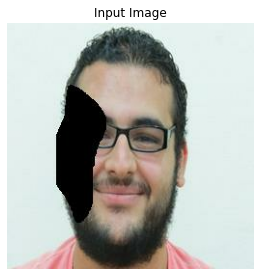

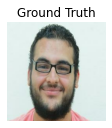

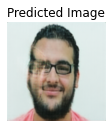

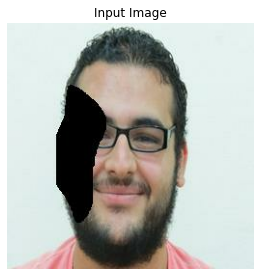

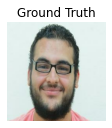

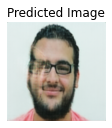

Time taken for epoch 1 is 91.67878365516663 sec



TypeError: ignored

In [10]:

train(train_dataset, EPOCHS,load_weight)

'''
Restore the latest checkpoint and test
'''
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

'''
Testing on the entire test dataset
'''
# Run the trained model on the entire test dataset
for inp, tar in test_dataset:
    generate_images(generator, inp, tar)


In [46]:

# Compute PSNR over tf.uint8 Tensors.
import numpy as np
import math
import cv2

psnr_g=[]
for te in range(1, 11):
    contrast1='generator/g'+str(te)+'.jpg';
    original1='target/t1.jpg'
    original = cv2.imread(original1)
    contrast = cv2.imread(contrast1)
    def psnr(img1, img2):
        mse = np.mean( (img1 - img2) ** 2 )
        if mse == 0:
         return 100
        PIXEL_MAX = 255.0
        return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))
    psnr_g.append(psnr(original,contrast))
#print(psnr_g)
    #Mean Squared Error vs. Structural Similarity Measure
findimage_PSNR=0    
maxElement = np.amax(psnr_g)
for i in range(1,11):
  if maxElement==psnr_g[i]:
    findimage_PSNR=i+1
    print('Measurement of PSNR for the image number '+str(findimage_PSNR)+', it is most closest to the target(1) image')
    break

Measurement of PSNR for the image number 5, it is most closest to the target(1) image


In [47]:

MSE=[]
for te in range(1, 11):
    contrast1='generator/g'+str(te)+'.jpg';
    original1='target/t1.jpg'
    imageA = cv2.imread(original1)
    imageB = cv2.imread(contrast1)
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
     
    MSE.append(err)
findimage_MSE=0    
minElement = np.amin(MSE)
for i in range(0,10):
  if minElement==MSE[i]:
    findimage_MSE=i+1
    print('Measurement of MSE for the image number '+str(findimage_MSE)+', it is most closest to the target(1) image')
    break 

Measurement of MSE for the image number 1, it is most closest to the target(1) image


In [26]:
!pip install SSIM_PIL

In [48]:
from skimage.measure import compare_ssim
from PIL import Image
    
    
SSIM=[]
for te in range(1, 11):
  contrast1='generator/g'+str(te)+'.jpg';
  original1='target/t1.jpg'
  im1 = tf.image.decode_image(tf.io.read_file(contrast1))
  im2 = tf.image.decode_image(tf.io.read_file(original1))
  tf.shape(im1)  # img1.png has 3 channels; shape is (255, 255, 3)
  tf.shape(im2)  # img2.png has 3 channels; shape is (255, 255, 3)
  # Add an outer batch for each image.
  im1 = tf.expand_dims(im1, axis=0)
  im2 = tf.expand_dims(im2, axis=0)
  # Compute SSIM over tf.uint8 Tensors.
  ssim1 = tf.image.ssim(im1, im2, max_val=255, filter_size=11,
                        filter_sigma=1.5, k1=0.01, k2=0.03)

  # Compute SSIM over tf.float32 Tensors.
  im1 = tf.image.convert_image_dtype(im1, tf.float32)
  im2 = tf.image.convert_image_dtype(im2, tf.float32)
  SSIM.append(tf.image.ssim(im1, im2, max_val=1.0, filter_size=11,
                        filter_sigma=1.5, k1=0.01, k2=0.03))
    # ssim1 and ssim2 both have type tf.float32 and are almost equal.
SSIM=np.array(SSIM)
findimage_SSIM=0    
maxElement = np.amax(SSIM)
for i in range(0,10):
  if maxElement==SSIM[i]:
    findimage_SSIM=i+1
    print('Measurement of SSIM for the image number '+str(findimage_SSIM)+', it is most closest to the target(1) image')
    break

Measurement of SSIM for the image number 1, it is most closest to the target(1) image


In [54]:
#fusion_decision Measurement
fusion_decision=[]
fusion_decision.append(findimage_PSNR)
fusion_decision.append(findimage_MSE)
fusion_decision.append(findimage_SSIM)
print('Measurement of Fusion decision for the image number('+str(np.bincount(fusion_decision).argmax())+'), it is most closest to the target(1) image')


Measurement of Fusion decision for the image number(1), it is most closest to the target(1) image
